In [1]:
from sqlalchemy import func
from sqlalchemy import create_engine, Column, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.sql import func
from shapely.geometry import Polygon
import numpy as np
from shapely.geometry import shape
import shapely.plotting as shpplt
import json

import matplotlib.pyplot as plt

In [2]:
from geoalchemy2 import Geometry


Base = declarative_base()

class Annotation(Base):
    __tablename__ = 'geometries'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String, nullable=False)
    geom = Column(Geometry('POLYGON'), nullable=False)

# Create an SQLite database in memory
engine = create_engine('sqlite:///:memory:')
connection = engine.raw_connection()
connection.enable_load_extension(True)
connection.execute('SELECT load_extension("mod_spatialite")')
connection.close()

Base.metadata.create_all(engine)
Session = sessionmaker(bind=engine)

/tmp/ipykernel_1031/2640958386.py:4: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()
RecoverGeometryColumn() error: unexpected metadata layout
CreateSpatialIndex() error: "no such table: geometry_columns"


In [3]:
import random

num_polygons = 100

# Insert 100 sample geometries with random centroids
with Session() as session:
    for i in range(num_polygons):
        # Generate random centroid coordinates in range [-10, 10]
        cx, cy = random.uniform(-10, 10), random.uniform(-10, 10)
        # Create a polygon around the centroid
        polygon = Polygon([(cx + np.cos(theta), cy + np.sin(theta)) for theta in np.linspace(0, 2 * np.pi, 100)])
        session.add(Annotation(name=f'SamplePolygon_{i}', geom=polygon.wkt))
    session.commit()

In [4]:
# Query and return the geometry as GeoJSON
with Session() as session:
    query = session.query(func.ST_AsGeoJSON(Annotation.geom))
    result = query.all()

(<matplotlib.patches.PathPatch at 0x7eea67bac6d0>,
 <matplotlib.lines.Line2D at 0x7eea67bfeb60>)

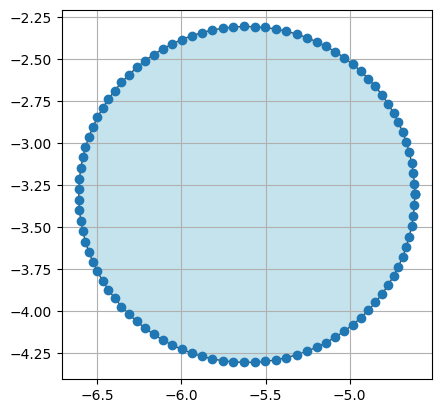

In [5]:
poly = shape(json.loads(result[0][0]))
shpplt.plot_polygon(poly, fc='lightblue', ec='black', alpha=0.7)

In [6]:
# Query and simplify the geometry
with Session() as session:
    query = session.query(func.ST_AsGeoJSON(func.ST_SimplifyPreserveTopology(Annotation.geom, 0.1)))
    result = query.all()


(<matplotlib.patches.PathPatch at 0x7eea67bac2b0>,
 <matplotlib.lines.Line2D at 0x7eea660c3070>)

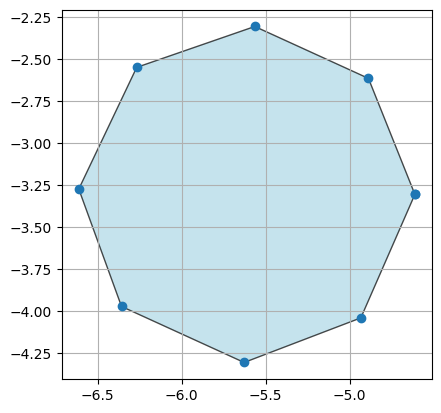

In [7]:
poly = shape(json.loads(result[0][0]))
shpplt.plot_polygon(poly, fc='lightblue', ec='black', alpha=0.7)

In [8]:


# Timing the query without simplification
def query_no_simplify():
    with Session() as session:
        session.query(func.ST_AsGeoJSON(Annotation.geom)).all()

# Timing the query with simplification
def query_with_simplify():
    with Session() as session:
        session.query(func.ST_AsGeoJSON(func.ST_SimplifyPreserveTopology(Annotation.geom, 0.1))).all()



In [9]:
%%time
query_no_simplify()

CPU times: user 18.6 ms, sys: 14.3 ms, total: 32.9 ms
Wall time: 10.7 ms


In [10]:
%%time
query_with_simplify()

CPU times: user 12.2 ms, sys: 18.3 ms, total: 30.5 ms
Wall time: 10.1 ms


In [11]:
%%timeit
query_no_simplify()

8.81 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:

%%timeit
query_with_simplify()

8.57 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
# Drop the table (optional cleanup step)
Base.metadata.drop_all(engine)

CheckSpatialIndex SQL error: no such table: geometry_columns
DiscardGeometryColumn: "no such table: geometry_columns"


## Results
| Method                 | Time (ms) |
|------------------------|-----------|
| Without Simplification (100 polygons) | 9.52 |
| With Simplification (100 polygons)    | 8.61     |
| Without Simplification (1 polygons) | 1.97   |
| With Simplification (1 polygons)    | 2.43     |
| Without Simplification (1 polygons, timeit) | 840 µs ± 14.3 µs per loop |
| With Simplification (1 polygons, timeit)    | 987 µs ± 13.7 µs per loop     |
